In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [45]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

## 증시 예측
- 데이터 유효성, 누락 검사
- 분포, 상관관계 분석
- 전처리 : X(이동 평균(5일?), 하루 전?), Y(다음날 종가? 거래량?) 분리, 정규화
- LinearRegression 점수 측정, tensorflow 뉴럴 네트워크로 점수 측정
- 그래프로 시각화 (역 정규화) 

In [310]:
삼성 = '005930'
삼천리자전거 = '024950'
url_base = 'https://finance.naver.com/item/sise_day.nhn?code='
url = url_base + 삼성 +'&page='
page_list = []
max_page = 31 
for page in range(1, max_page):
    tables = pd.read_html(url+str(page))
    page_list.append(tables[0]) # 네이버는 첫번쨰 테이블[0]이 증시데이터 입니다.
len(page_list)

30

In [311]:
df = pd.concat(page_list, axis=0)
df = df.dropna()
df = df.set_index('날짜').drop(columns='전일비')
df = df.iloc[::-1] # 행을 반대로 뒤집기 

In [312]:
df.isna().sum().sum()

0

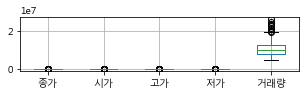

In [313]:
df.boxplot(figsize=(5,1))

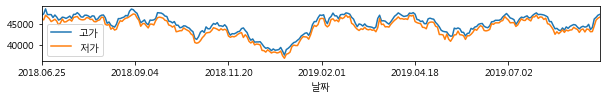

In [314]:
df[['고가', '저가']].plot(figsize=(10,1))

In [315]:
df.corr()

,종가,시가,고가,저가,거래량
종가,1.000000,0.970831,0.988029,0.987951,-0.270299
시가,0.970831,1.000000,0.986696,0.988068,-0.259626
고가,0.988029,0.986696,1.000000,0.988656,-0.227901
저가,0.987951,0.988068,0.988656,1.000000,-0.297244
거래량,-0.270299,-0.259626,-0.227901,-0.297244,1.000000


In [316]:
x = df.iloc[:-1] # 전날
y = df.iloc[1:]['종가'] # 다음날

In [317]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(x, y)
model.score(x, y)

0.9114887869241718

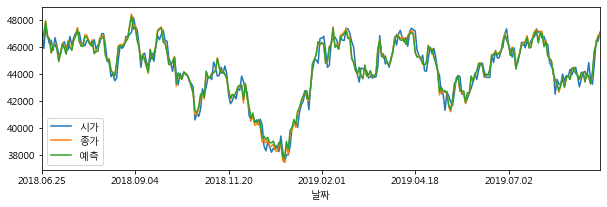

In [318]:
df[['시가', '종가']].plot(figsize=(10, 3))
plt.plot(model.predict(x), label='예측')
plt.legend()

전일비를 추가하자

In [319]:
#전일비 = 다음날 ? - 전날 ?
전일비 = df.iloc[1:]['시가']  - df.iloc[:-1]['종가'] 
df['전일비'] = 전일비
df = df.dropna()
#전일비

이동평균을 넣어보자

In [320]:
df_rol = df.rolling(window=5).mean()

In [321]:
df_rol.columns = ['종가_rol', '시가_rol', '고가_rol', '저가_rol', '거래량_rol','전일비_rol'] 

In [322]:
df_con = pd.concat((df, df_rol), axis=1).dropna()
df_con.head(1)

,종가,시가,고가,저가,거래량,전일비,종가_rol,시가_rol,고가_rol,저가_rol,거래량_rol,전일비_rol
날짜,,,,,,,,,,,,
2018.07.02,45550.0,46500.0,47150.0,45500.0,13112253.0,950.0,46790.0,46590.0,47450.0,46240.0,13298921.2,-200.0


In [323]:
x = df_con.iloc[:-1] # 전날
y = df_con.iloc[1:]['종가'] # 다음날

In [324]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(x, y)
model.score(x, y) #0.935 > 0.936

0.9128123959335408

In [325]:
import tensorflow as tf
x = np.array(x).astype(np.float32)
y = np.array(y).astype(np.float32).reshape([-1, 1])
x.shape, y.shape, np.min(y), np.max(y)

((293, 12), (293, 1), 37450.0, 48450.0)

In [326]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
scaler_x = MinMaxScaler().fit(x)
scaler_y = MinMaxScaler().fit(y)
xn = scaler_x.transform(x)
yn = scaler_y.transform(y)
np.min(xn), np.max(xn), np.min(yn), np.max(yn)

(0.0, 1.0, 0.0, 1.0)

In [327]:
w1 = tf.Variable(tf.random_normal(shape=[12,20]))
b1 = tf.Variable(tf.random_normal(shape=[20]))
w2 = tf.Variable(tf.random_normal(shape=[20,1]))
b2 = tf.Variable(tf.random_normal(shape=[1]))
h1 = tf.sigmoid(tf.matmul(xn, w1) + b1)
out = tf.matmul(h1, w2) + b2
cost = tf.reduce_mean((yn-out)**2)
train = tf.train.GradientDescentOptimizer(0.9).minimize(cost)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [ ]:
for i in range(10000):
    _, c = sess.run([train, cost])    
    if i%1000 == 0: print(i, c, r2_score(yn, sess.run(out)))
print(i, c, r2_score(yn, sess.run(out)))

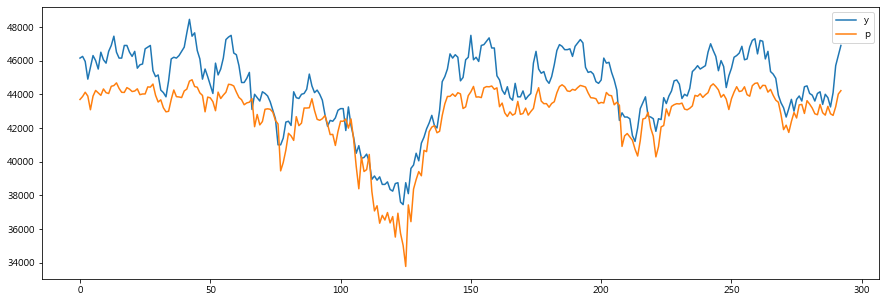

In [364]:
plt.figure(figsize=(15,5))
plt.plot(scaler_y.inverse_transform(yn), label='y')
plt.plot(scaler_y.inverse_transform(sess.run(out)), label='p')
plt.legend()